# About Q-Learning algorithm
> "Q-learning is a model-free reinforcement learning algorithm. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. It does not require a model (hence the connotation "model-free") of the environment, and it can handle problems with stochastic transitions and rewards, without requiring adaptations."
[*wiki*](https://en.wikipedia.org/wiki/Q-learning)

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import os
import keras

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
import gym

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 다른 gym 실험

gymnasium.make("Blackjack-v1")

In [4]:
import gym
keras.backend.clear_session()
env = gym.make("Blackjack-v1", natural = False, sab = False)
env.seed(77)
# input_shape = [4]
# n_outputs = 2

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[77]

In [5]:
# 환경 초기화
obs = env.reset()
obs

(17, 1, False)

In [6]:
env.render()
img = env.render(mode="rgb_array")
img.shape

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


(500, 600, 3)

In [7]:
# 이미지 변환 함수 정의
def plot_environment(env, figsize = (5,4)):
  plt.figure(figsize=figsize)
  img = env.render(mode="rgb_array")
  plt.imshow(img)
  plt.axis("off")
  return img

<function matplotlib.pyplot.show(close=None, block=None)>

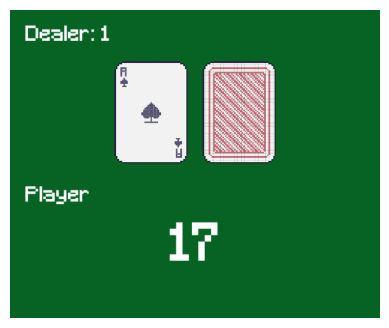

In [8]:
# 블랙잭 이미지 표시
plot_environment(env)
plt.show

In [9]:
# 행동할 수 있는 종류
env.action_space

Discrete(2)

관측(내 손, 딜러 손, 에이스 여부), 리워드, 결과값, 정보 : ((17, 1, False), -1.0, True, {'TimeLimit.truncated': False})


<function matplotlib.pyplot.show(close=None, block=None)>

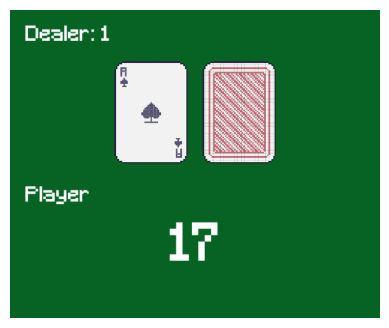

In [10]:
# 숫자 증가
action = 0
obs, reward, done, info = env.step(action)
print(f"관측(내 손, 딜러 손, 에이스 여부), 리워드, 결과값, 정보 : {env.step(action)}")
# obs = 플레이어의 현재 합계/ 딜러가 보여준 카드의 가치(값)/ 사용가능한 에이스로 구성
# 이미지 표시
plot_environment(env)
plt.show

In [11]:
# 리워드 표시
reward

-1.0

In [12]:
done, info

(True, {'TimeLimit.truncated': False})

In [13]:
# 간단한 policy
def basic_policy(obs):
  player_current_sum = obs[0]
  value_of_the_dealers_one = obs[1]
  usable_ace = obs[2]
  if usable_ace == True:
    usable_ace = 11
  else:
    usable_ace = 0
  player_final_score = abs(21 - (player_current_sum + usable_ace))
  dealer_final_score = abs(21 - value_of_the_dealers_one)
  # 플레이어 예측 vs 딜러 예측(실제 카드)
  # 21에서 카드 숫자를 제외한 점수의 절대값이 더 낮은 쪽이 승리로 가는 알고리즘
  # '21'보다 실제 카드 숫자가 더 클수도 있다는 점 고려
  # 에이스 카드 사용
  return 0 if player_final_score < dealer_final_score else 1
totals = []

In [14]:
basic_policy
# 리워드는 둘중 하나. 승(1)과 패(0)

<function __main__.basic_policy(obs)>

In [ ]:
# 에피소드 10회
for episode in range(100):
  episode_rewards = 0
  obs = env.reset()
  for step in range(10):
    action = basic_policy(obs)
    print(action)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [ ]:
totals[:20]

In [ ]:
# 프레임에 삽입
# 10 에피소드부터 시작
# player가 딜러를 이기는 순간 초기화
frames=[]
obs = env.reset()
for episode in range(20):
  episode_rewards = 0
  obs = env.reset()
  for step in range(10):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [18]:
# 카드 출력
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch,
# 기본 반복
def plot_animation(frames, repeat = True, interval=20):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames = len(frames), repeat=repeat, interval = interval
  )
  plt.close()
  return anim
plot_animation(frames)

#### Network policy 적용?

In [69]:
# 초기화
keras.backend.clear_session()
# 신경망 모델 정의
tf.random.set_seed(1)
np.random.seed(1)

n_inputs = 3 # == env.observation_space.shape[0]
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [70]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [71]:
# model.predict()
obs = env.reset()
obs

(20, 5, False)

In [146]:
# 모델 실행 > 에피소드 플레이 > 애니메이션 반환 함수 정의
n_inputs = 3 # == env.observation_space.shape[0]
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(2, activation="elu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

env = gym.make("Blackjack-v1")
def render_policy_net(model, n_max_steps=200, seed=3):
    frames = []
    env = gym.make("Blackjack-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        obs = np.array(obs)
        print(obs.reshape(1, -1))
        left_proba = model.predict(obs.reshape(1, -1))
        print(left_proba)
        # print(np.random.rand())
        action = int(np.random.rand() > left_proba)
        # print(action)
        obs, reward, done, info = env.step(action)
        if done:
          break
        obs = env.reset()
    return frames
frames = render_policy_net(model)
frames

[[ 7 10  0]]
1/1 [==============================] - 0s 63ms/step
[[0.99998546]]


[array([[[ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36],
         ...,
         [ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36]],
 
        [[ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36],
         ...,
         [ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36]],
 
        [[ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36],
         ...,
         [ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36]],
 
        ...,
 
        [[ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36],
         ...,
         [ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36]],
 
        [[ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36],
         ...,
         [ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36]],
 
        [[ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36],
         ...,
         [ 7, 99, 36],
         [ 7, 99, 36],
         [ 7, 99, 36]]], dtype=uint8)]

In [143]:
plot_animation(frames)

In [154]:
# cart-pole 참조
# 사용자 정의 훈련
n_environments = 50
n_iterations = 5000
envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy
observations

[array([ 0.01369617, -0.02302133, -0.04590265, -0.04834723], dtype=float32),
 array([ 0.00118216,  0.04504637, -0.03558404,  0.04486495], dtype=float32),
 array([-0.02383879, -0.02015088,  0.03142257, -0.04080841], dtype=float32),
 array([-0.04143508, -0.02631895,  0.03012745,  0.0082162 ], dtype=float32),
 array([ 0.04430561,  0.00113276,  0.04762437, -0.0419164 ], dtype=float32),
 array([ 0.03050029,  0.03079408,  0.00153256, -0.02141986], dtype=float32),
 array([ 0.00381644, -0.01567291, -0.01309328, -0.01255032], dtype=float32),
 array([ 0.01250955,  0.03972138,  0.02756857, -0.02747928], dtype=float32),
 array([-0.01730277,  0.04872768, -0.01812892,  0.02885489], dtype=float32),
 array([ 0.03702492, -0.02131828,  0.01031481,  0.02775341], dtype=float32),
 array([ 0.04560017, -0.02923182,  0.03284449, -0.03507179], dtype=float32),
 array([-3.7142981e-02, -7.2213756e-05,  1.0149836e-02, -4.7131099e-02],
       dtype=float32),
 array([-0.02491755,  0.04467529, -0.03106796, -0.0320708

#### 사용자 정의 훈련

In [168]:
# 사용자 정의 훈련
n_environments = 50
n_iterations = 5000
envs = [gym.make("Blackjack-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
observations = [np.array(env.reset(), dtype="float32") for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy
observations

[array([11., 10.,  0.], dtype=float32),
 array([20.,  7.,  0.], dtype=float32),
 array([ 6., 10.,  0.], dtype=float32),
 array([ 7., 10.,  0.], dtype=float32),
 array([17., 10.,  0.], dtype=float32),
 array([21.,  9.,  1.], dtype=float32),
 array([12.,  6.,  0.], dtype=float32),
 array([19., 10.,  0.], dtype=float32),
 array([14., 10.,  0.], dtype=float32),
 array([14.,  6.,  0.], dtype=float32),
 array([ 7., 10.,  0.], dtype=float32),
 array([17.,  2.,  0.], dtype=float32),
 array([20.,  8.,  0.], dtype=float32),
 array([20., 10.,  0.], dtype=float32),
 array([14.,  2.,  0.], dtype=float32),
 array([20., 10.,  0.], dtype=float32),
 array([16.,  8.,  0.], dtype=float32),
 array([ 5., 10.,  0.], dtype=float32),
 array([13., 10.,  0.], dtype=float32),
 array([15.,  8.,  0.], dtype=float32),
 array([10., 10.,  0.], dtype=float32),
 array([14.,  4.,  0.], dtype=float32),
 array([12., 10.,  0.], dtype=float32),
 array([15.,  1.,  0.], dtype=float32),
 array([16.,  5.,  0.], dtype=float32),


In [169]:
# 그라디언트 자동 미분 이용
# 100회 반복 훈련 후 에피소드 진행하고 자동 업데이트
for iteration in range(n_iterations):
    player_current_sum = obs[0]
    value_of_the_dealers_one = obs[1]
    usable_ace = obs[2]
    if usable_ace == True:
      usable_ace = 11
    else:
      usable_ace = 0
    player_final_score = abs(21 - (player_current_sum + usable_ace))
    dealer_final_score = abs(21 - value_of_the_dealers_one)
    # 플레이어 예측 vs 딜러 예측(실제 카드)
    # 21에서 카드 숫자를 제외한 점수의 절대값이 더 낮은 쪽이 승리로 가는 알고리즘
    # '21'보다 실제 카드 숫자가 더 클수도 있다는 점 고려
    # 에이스 카드 사용
    target_probas = np.array([([0] if player_final_score < dealer_final_score else [1.]) for obs in observations])
    # target_probas = np.array([([1.] if obs[2] < 0 else [0]) for obs in observations])
    with tf.GradientTape() as tape:
      left_probas = model(np.array(observations))
      loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\r Iteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
      obs, reward, done, info = env.step(actions[env_index][0])
      observations[env_index] = obs if not done else env.reset()
for env in envs:
  env.close()

 Iteration: 4999, Loss: 8.513

In [170]:
#  이미지 애니메이션
frames = render_policy_net(model)
plot_animation(frames)

[[ 7 10  0]]
1/1 [==============================] - 0s 22ms/step
[[0.99998546]]


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
